### Importing Packages 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from keras.utils.np_utils import to_categorical
import nltk
from nltk.corpus import stopwords
import re
from keras.preprocessing.text import Tokenizer
import gensim
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from sklearn.metrics import accuracy_score
import joblib

In [6]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Knight ML Assignment/Data/train.csv')

### EDA(Exploratory  Data Analysis)

In [4]:
train.head()

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety
0,NaN,Australia,Andrew Peace 2007 Peace Family Vineyard Chardo...,"Classic Chardonnay aromas of apple, pear and h...",Peace Family Vineyard,83,10.0,Australia Other,South Eastern Australia,NaN,Andrew Peace,Chardonnay
1,@wawinereport,US,North by Northwest 2014 Red (Columbia Valley (...,This wine is near equal parts Syrah and Merlot...,NaN,89,15.0,Washington,Columbia Valley (WA),Columbia Valley,North by Northwest,Red Blend
2,NaN,Italy,Renato Ratti 2007 Conca (Barolo),Barolo Conca opens with inky dark concentratio...,Conca,94,80.0,Piedmont,Barolo,NaN,Renato Ratti,Nebbiolo
3,@vossroger,France,Domaine l'Ancienne Cure 2010 L'Abbaye White (B...,It's impressive what a small addition of Sauvi...,L'Abbaye,87,22.0,Southwest France,Bergerac Sec,NaN,Domaine l'Ancienne Cure,Bordeaux-style White Blend
4,@vossroger,France,Château du Cèdre 2012 Le Cèdre Vintage Malbec ...,"This ripe, sweet wine is rich and full of drie...",Le Cèdre Vintage,88,33.0,France Other,Vin de Liqueur,NaN,Château du Cèdre,Malbec


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82657 entries, 0 to 82656
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_name           63264 non-null  object 
 1   country             82622 non-null  object 
 2   review_title        82657 non-null  object 
 3   review_description  82657 non-null  object 
 4   designation         59010 non-null  object 
 5   points              82657 non-null  int64  
 6   price               77088 non-null  float64
 7   province            82622 non-null  object 
 8   region_1            69903 non-null  object 
 9   region_2            35949 non-null  object 
 10  winery              82657 non-null  object 
 11  variety             82657 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 7.6+ MB


In [6]:
train.isnull().sum()

user_name             19393
country                  35
review_title              0
review_description        0
designation           23647
points                    0
price                  5569
province                 35
region_1              12754
region_2              46708
winery                    0
variety                   0
dtype: int64

In [7]:
train.describe(include='all')

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety
count,63264,82622,82657,82657,59010,82657.000000,77088.000000,82622,69903,35949,82657,82657
unique,15,38,76983,77628,26424,NaN,NaN,358,1019,17,13786,28
top,@vossroger,US,Korbel NV Brut Sparkling (California),"Stewed plum, savory herb and tobacco aromas ca...",Reserve,NaN,NaN,California,Napa Valley,Central Coast,Testarossa,Pinot Noir
freq,17539,38573,8,2,1382,NaN,NaN,25736,3334,7503,175,10587
mean,NaN,NaN,NaN,NaN,NaN,88.544564,36.922232,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,3.099649,43.698346,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,80.000000,4.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,86.000000,18.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,88.000000,27.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,91.000000,45.000000,NaN,NaN,NaN,NaN,NaN


In [0]:
mean_variety_price = train[['variety','price']].groupby(['variety'],as_index=False).mean().sort_values(by = 'price',ascending=False)

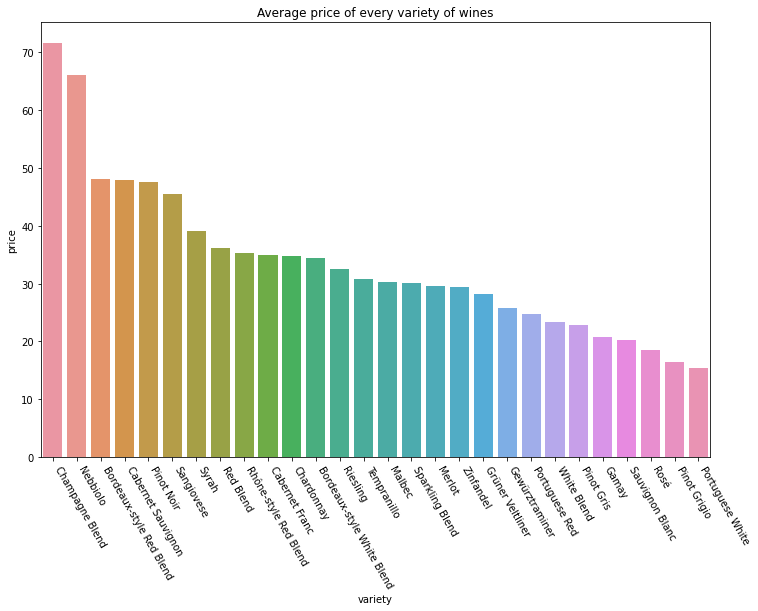

In [10]:
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(x='variety',y='price',data = mean_variety_price)
ax.set_xticklabels(ax.get_xticklabels(), rotation=300, ha="left")
plt.title("Average price of every variety of wines")
plt.show()

In [0]:
mean_variety_points = train[['variety','points']].groupby(['variety'],as_index=False).mean().sort_values(by = 'points',ascending=False)

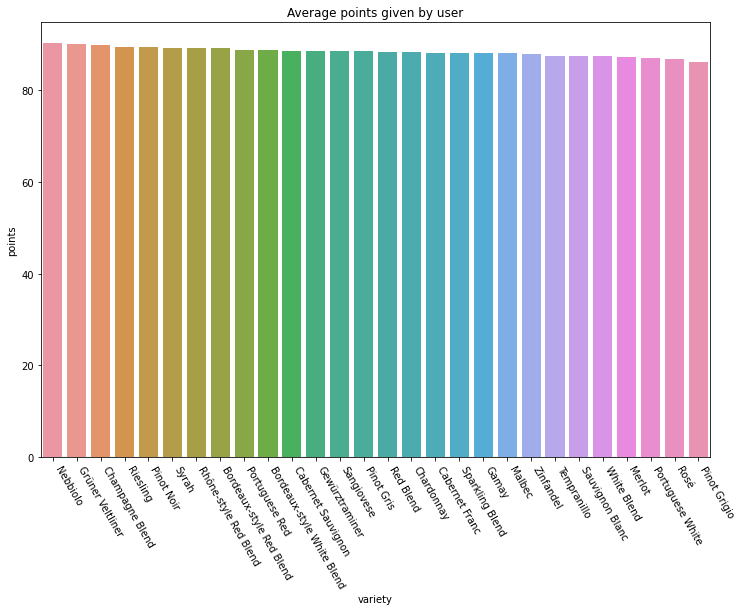

In [12]:
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(x='variety',y='points',data = mean_variety_points)
ax.set_xticklabels(ax.get_xticklabels(), rotation=300, ha="left")
plt.title("Average points given by user")
plt.show()


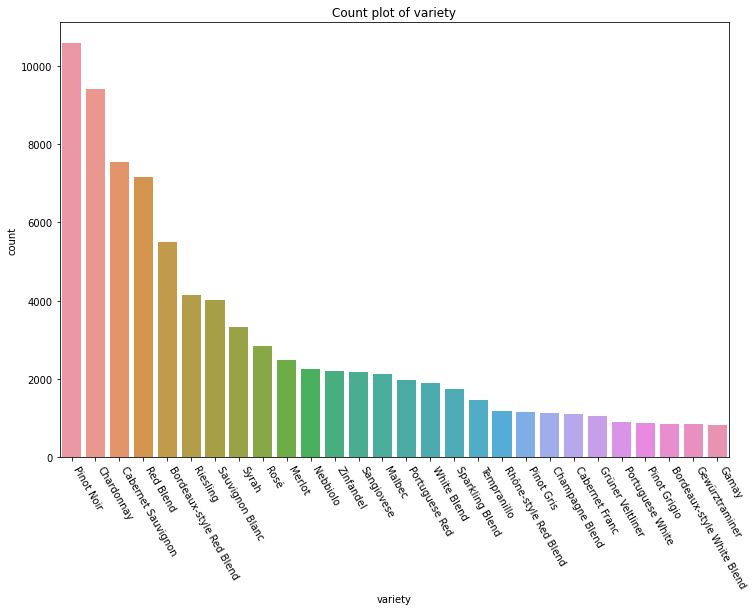

In [13]:
fig = plt.figure(figsize=(12,8))
ax = sns.countplot('variety',data=train,order = train['variety'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=300, ha="left")
plt.title('Count plot of variety')
plt.show()

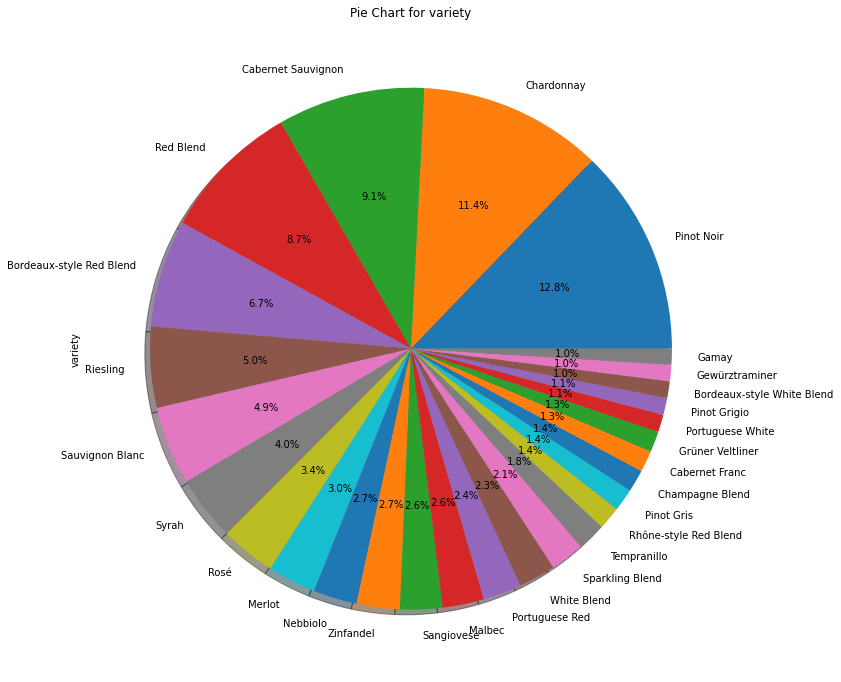

In [14]:
fig = plt.figure(figsize=(12,12))
train['variety'].value_counts().plot(kind='pie',autopct='%1.1f%%',shadow=True)
plt.title('Pie Chart for variety')
plt.show()


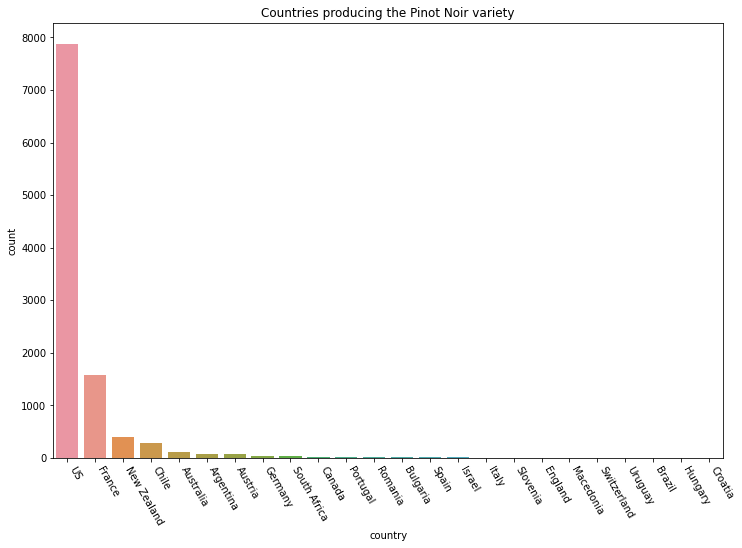

In [15]:
fig = plt.figure(figsize=(12,8))
ax = sns.countplot('country',data=train[train['variety']=='Pinot Noir'],order = train[train['variety']=='Pinot Noir']['country'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=300, ha="left")
plt.title('Countries producing the Pinot Noir variety')
plt.show()

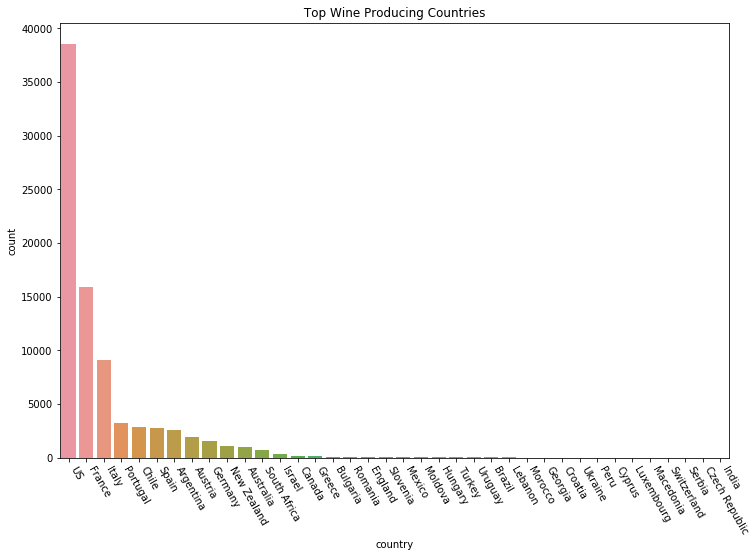

In [7]:
fig = plt.figure(figsize=(12,8))
ax = sns.countplot('country',data=train,order = train['country'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=300, ha="left")
plt.title(' Top Wine Producing Countries ')
plt.show()

### Review Processing using NLP

In [0]:
stop_words=set(stopwords.words('english'))
stop_words.remove('not')

In [0]:
def create_documents(text):
    text=re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+',' ',text)
    text=text.lower()
    text=text.split()
    text=[word for word in text if not word in stop_words]
    text=' '.join(text)
    return text

In [0]:
train['cleaned_review_description'] = train['review_description'].apply(create_documents)
train['cleaned_review_title'] = train['review_title'].apply(create_documents)

In [0]:
train['review_documents'] = train['cleaned_review_title'] + train['cleaned_review_description']

### Creating Word2Vec Model for LSTM

In [0]:
documents = [text.split() for text in train['review_documents']]

In [25]:
w2v_model = gensim.models.word2vec.Word2Vec(size=300, workers=8)
w2v_model.build_vocab(documents)
w2v_model.train(documents, total_examples=len(documents), epochs=30)

(69333383, 80338290)

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['review_documents'])
vocab_size=len(tokenizer.word_index)+1
vocab_size

75481

In [0]:
X = train['review_documents']
y = train['variety']

In [0]:
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)
y=to_categorical(y)

In [0]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=123)

In [0]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=300)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=300)

In [31]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(75481, 300)


In [0]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300,trainable = False)

### LSTM Model 

In [33]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(output_dim=28,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          22644300  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 28)                2828      
Total params: 22,807,528
Trainable params: 163,228
Non-trainable params: 22,644,300
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=28)`
  """


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [35]:
model_history=model.fit(X_train, y_train,batch_size=1024,epochs=15,validation_split=0.1,verbose=1)

Train on 59512 samples, validate on 6613 samples
Epoch 1/15
59512/59512 [==============================] - 50s 848us/step - loss: 0.1316 - accuracy: 0.9644 - val_loss: 0.1003 - val_accuracy: 0.9677
Epoch 2/15
59512/59512 [==============================] - 47s 795us/step - loss: 0.0897 - accuracy: 0.9701 - val_loss: 0.0609 - val_accuracy: 0.9788
Epoch 3/15
59512/59512 [==============================] - 48s 804us/step - loss: 0.0533 - accuracy: 0.9811 - val_loss: 0.0305 - val_accuracy: 0.9894
Epoch 4/15
59512/59512 [==============================] - 48s 801us/step - loss: 0.0302 - accuracy: 0.9894 - val_loss: 0.0188 - val_accuracy: 0.9937
Epoch 5/15
59512/59512 [==============================] - 48s 811us/step - loss: 0.0206 - accuracy: 0.9932 - val_loss: 0.0146 - val_accuracy: 0.9950
Epoch 6/15
59512/59512 [==============================] - 47s 796us/step - loss: 0.0167 - accuracy: 0.9943 - val_loss: 0.0127 - val_accuracy: 0.9955
Epoch 7/15
59512/59512 [==============================] -

### Plotting Accuracy and Loss graphs 

In [0]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs=range(len(acc))

Text(0.5, 1.0, 'Training and Validation Accuracy')

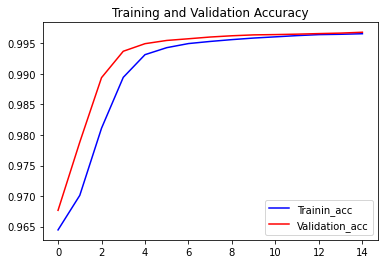

In [37]:
plt.plot(epochs,acc,label='Trainin_acc',color='blue')
plt.plot(epochs,val_acc,label='Validation_acc',color='red')
plt.legend()
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation loss')

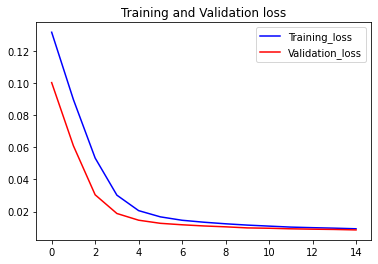

In [38]:
plt.plot(epochs,loss,label='Training_loss',color='blue')
plt.plot(epochs,val_loss,label='Validation_loss',color='red')
plt.legend()
plt.title("Training and Validation loss")

In [39]:
predictions = model.predict(X_test, verbose=1, batch_size=1024)

16532/16532 [==============================] - 3s 195us/step


In [0]:
y_pred = np.argmax(predictions,axis=1)
y_test = np.argmax(y_test,axis=1)

In [41]:
print('accuracy:',accuracy_score(y_pred,y_test))

accuracy: 0.9592305831115413


In [42]:
############# Saving the models to the pickle file ##########

joblib.dump(w2v_model,'/content/drive/My Drive/Colab Notebooks/Knight ML Assignment/word2vec.pkl')
joblib.dump(tokenizer,'/content/drive/My Drive/Colab Notebooks/Knight ML Assignment/tokenizer.pkl')
joblib.dump(model,'/content/drive/My Drive/Colab Notebooks/Knight ML Assignment/model.pkl')

['/content/drive/My Drive/Colab Notebooks/Knight ML Assignment/model.pkl']

### Predicting for the test Data

In [0]:
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Knight ML Assignment/Data/test.csv')

In [44]:
test.head()

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery
0,@paulgwine,US,Boedecker Cellars 2011 Athena Pinot Noir (Will...,Nicely differentiated from the companion Stewa...,Athena,88,35.0,Oregon,Willamette Valley,Willamette Valley,Boedecker Cellars
1,@wineschach,Argentina,Mendoza Vineyards 2012 Gran Reserva by Richard...,"Charred, smoky, herbal aromas of blackberry tr...",Gran Reserva by Richard Bonvin,90,60.0,Mendoza Province,Mendoza,NaN,Mendoza Vineyards
2,@vboone,US,Prime 2013 Chardonnay (Coombsville),"Slightly sour and funky in earth, this is a re...",NaN,87,38.0,California,Coombsville,Napa,Prime
3,@wineschach,Argentina,Bodega Cuarto Dominio 2012 Chento Vineyard Sel...,"This concentrated, midnight-black Malbec deliv...",Chento Vineyard Selection,91,20.0,Mendoza Province,Mendoza,NaN,Bodega Cuarto Dominio
4,@kerinokeefe,Italy,SassodiSole 2012 Brunello di Montalcino,"Earthy aromas suggesting grilled porcini, leat...",NaN,90,49.0,Tuscany,Brunello di Montalcino,NaN,SassodiSole


In [0]:
test['cleaned_review_description'] = test['review_description'].apply(create_documents)
test['cleaned_review_title'] = test['review_title'].apply(create_documents)

In [0]:
test['review_documents'] = test['cleaned_review_title'] + test['cleaned_review_description']

In [47]:
test_pred = model.predict(pad_sequences(tokenizer.texts_to_sequences(test['review_documents']), maxlen=300), verbose=1, batch_size=1024)

20665/20665 [==============================] - 4s 198us/step


In [0]:
test_pred = np.argmax(test_pred,axis=1)
test_pred = labelencoder.inverse_transform(test_pred)

In [49]:
test_pred

array(['Pinot Noir', 'Malbec', 'Chardonnay', ..., 'Cabernet Sauvignon',
       'Rosé', 'Cabernet Sauvignon'], dtype=object)

In [0]:
test['predicted_variety'] = test_pred

In [0]:
test[['user_name', 'country', 'review_title', 'review_description',
       'designation', 'points', 'price', 'province', 'region_1', 'region_2',
       'winery', 'predicted_variety']].to_csv('/content/drive/My Drive/Colab Notebooks/Knight ML Assignment/Submission.csv', index=False)